# CmpE 549 - Bioinformatics
## Assignment 1

**Name&Surname:** Emre Girgin \
**ID:** 2021700060

In [1]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from Bio import SeqIO, Phylo
from Bio.Phylo.BaseTree import Clade, Tree

np.random.seed(42)
main_path = "./UK-Coronavirus-Data/UK Coronavirus Data/Coronavirus Samples/"

### Question 1

In [2]:
fasta_path_aligned = main_path + "England (NOV032020)/HCOV19-ENGLAND-031120-A.fasta"

#### a-)

In [3]:
def get_samples(path, n=20):
    samples = []
    with open(path) as handle:
        for record in SeqIO.parse(handle, "fasta"):
            record = [nucleotide for nucleotide in str(record.seq)]
            record = ["-" if (nucleotide != "A" and nucleotide != "T" and nucleotide != "G" and nucleotide != "C") else nucleotide for nucleotide in record]
            samples.append(record)

    if n != -1:
        return np.asarray(samples[:n])
    else:
        return np.asarray(samples)

#### b-)

In [4]:
from matplotlib.pyplot import figure


def visualize(samples, n):
    figure(figsize=(15, 10), dpi=150)
    
    samples = samples[:, :n]
    
    nucleotide_types = ["-", "A", "T", "G", "C"]
    n_nucleotide_types = 5
    
    colormap = np.asarray([
        [1, 1, 1], # indel
        [1, 0, 0], # A
        [0, 1, 0], # T
        [0, 0, 1], # G
        [0, 0, 0] # C
    ])
        
    img = np.zeros((samples.shape[0], n, 3))
    
    for row, seq in enumerate(samples):
        for col, nucleotide in enumerate(seq):
            if nucleotide == "-":
                img[row, col] = colormap[0]
            elif nucleotide == "A":
                img[row, col] = colormap[1]
            elif nucleotide == "T":
                img[row, col] = colormap[2]
            elif nucleotide == "G":
                img[row, col] = colormap[3]
            elif nucleotide == "C":
                img[row, col] = colormap[4]
            else:
                return 0
            
    plt.imshow(img)
    plt.title("Sequences")
    plt.show()
    
    colormap = colormap.reshape(1,n_nucleotide_types,3)/1.0
    plt.imshow(colormap)
    plt.title("Colormap: {}".format("/".join(nucleotide_types)))
    plt.show()
    
    
    
            

In [5]:
samples_20 = get_samples(path=fasta_path_aligned, n=20)
samples_20 = samples_20[:, 21563:25385]

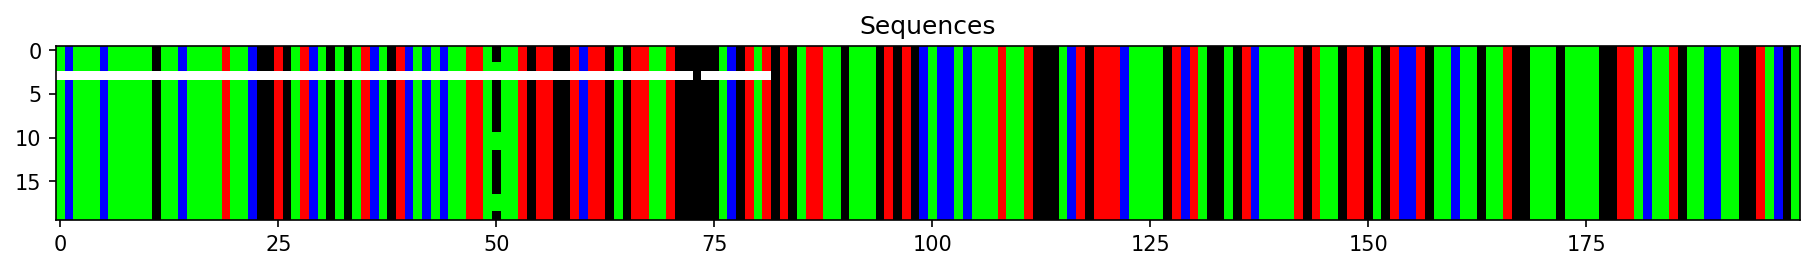

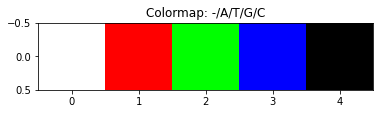

In [6]:
visualize(samples_20, 200)

#### c-)
We can see the obvious patterns in the columns of the visualization plot. Most of the sequences has almost the same order of nucleotides. However, there are some obvious outliers. For example starting from zero to around *80th* nucleotide, the third sequence has indels in it. Another one is at the 50th nucleotide. This may be caused by a mutation.

#### d-)

In [7]:
samples_100 = get_samples(path=fasta_path_aligned, n=100)

In [8]:
def entropy(samples):
    
    n_seq = samples.shape[0]
    t_ent = 0
    
    for column in samples.T:
        col_ent = 0
        value, count = np.unique(column, return_counts=True)
        for c in count:
            p_x = c/n_seq
            col_ent -= p_x * np.log(p_x)
            
        t_ent += col_ent
    return col_ent

print("Entropy of 100 aligned samples: {}".format(entropy(samples_100)))

Entropy of 100 aligned samples: 0.3863867062886037


### Question 2

In [9]:
fasta_path_unaligned = main_path + "England (NOV032020)/HCOV19-ENGLAND-031120.fasta"

#### a-)

In [10]:
samples_unaligned = get_samples(path=fasta_path_unaligned, n=5) # read all
samples_unaligned = [samples_unaligned[i][21600:21800] for i in range(samples_unaligned.shape[0])]
samples_unaligned = np.asarray(samples_unaligned)

/tmp/ipykernel_10046/230746868.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(samples[:n])


In [11]:
#samples_unaligned = samples_unaligned[:, 21600:21800]
print("Unaligned Shape: {}".format(samples_unaligned.shape))

Unaligned Shape: (5, 200)


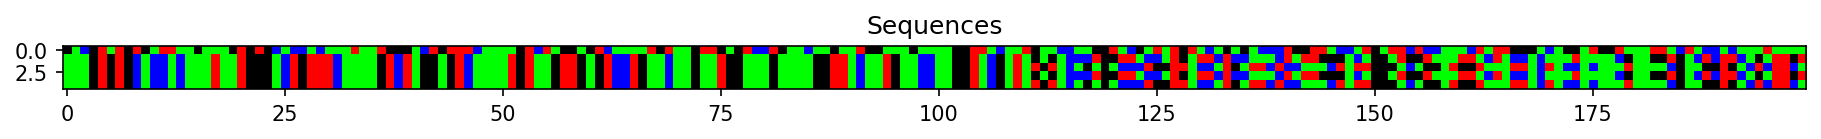

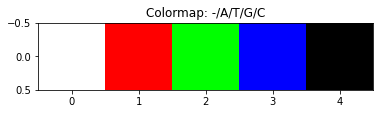

In [12]:
visualize(samples_unaligned, n=200)

#### b-) 

In [13]:
# Adjusted from my previous implementations 
# Source: https://github.com/egirgin/senior-projects/blob/master/493-Inf-Retrv/p1-edit-distance/edit-distance.py
def needlemanWunsch(s1, s2):
    cost = -4
    reward = 5
    
    alignmentMatrix = np.zeros((len(s1)+1, len(s2)+1))

    for i in range(len(s1)+1):
        alignmentMatrix[i][0] = i*cost
    for i in range(len(s2)+1):
        alignmentMatrix[0][i] = i*cost
    for i in range(1,len(s1)+1):
        for j in range(1,len(s2)+1):
            if s1[i-1] == s2[j-1]:
                alignmentMatrix[i][j] = max(
                    alignmentMatrix[i-1][j] + cost, # Delete
                    alignmentMatrix[i][j-1] + cost, # Insert
                    alignmentMatrix[i-1][j-1] + reward # Copy
                )
            else:
                alignmentMatrix[i][j] = max(
                    alignmentMatrix[i-1][j] + cost, # Delete
                    alignmentMatrix[i][j-1] + cost, # Insert
                    alignmentMatrix[i-1][j-1] + cost # Replace
                )
    return np.asarray(alignmentMatrix)

#### c-)

Note that the pairwise scores obtained by Needleman-Wunsch global sequence alignment algorithm is normalized to be used as a distance metric as follows: $$\$$

$$dist(i,j) = max(alignmentMatrix) - alignmentScore(i,j)$$

In [14]:
def distance_matrix(samples):

    pairwise_dists = np.zeros((samples.shape[0], samples.shape[0]))

    for id1 in range(samples.shape[0]):
        for id2 in range(id1, samples.shape[0]):
            seq1 = samples[id1]
            seq2 = samples[id2]
            
            seq1 = "".join(seq1)
            seq2 = "".join(seq2)
            pairwise_dists[id2, id1] = needlemanWunsch(seq1, seq2)[-1, -1]
            
    max_element = np.max(pairwise_dists)
    
    pairwise_dists = max_element - pairwise_dists
    pairwise_dists[pairwise_dists == max_element] = 0

    return pairwise_dists

pairwise_dists = distance_matrix(samples_unaligned)
print(pairwise_dists)

[[  0.   0.   0.   0.   0.]
 [286.   0.   0.   0.   0.]
 [208.  78.   0.   0.   0.]
 [286.   0.  78.   0.   0.]
 [208.  78.   0.  78.   0.]]


#### d-)

In [15]:
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

def convert2Phylo(samples):
    samples = [ SeqRecord(Seq("".join(seq)), id=str(idx)) for idx, seq in enumerate(samples)]
    return MultipleSeqAlignment(samples)
    
    
alignment_seq = convert2Phylo(samples_unaligned)

In [16]:
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix

tree_matrix = [row[:idx+1].tolist() for idx, row in enumerate(np.tril(pairwise_dists, 0))]
constructor = DistanceTreeConstructor()
tree = constructor.nj(DistanceMatrix(names=['0', '1', '2', '3', '4'], matrix=tree_matrix))
print(tree)

Tree(rooted=False)
    Clade(branch_length=0, name='Inner3')
        Clade(branch_length=0.0, name='Inner2')
            Clade(branch_length=208.0, name='0')
            Clade(branch_length=78.0, name='Inner1')
                Clade(branch_length=0.0, name='3')
                Clade(branch_length=0.0, name='1')
        Clade(branch_length=0.0, name='2')
        Clade(branch_length=0.0, name='4')


#### e-)

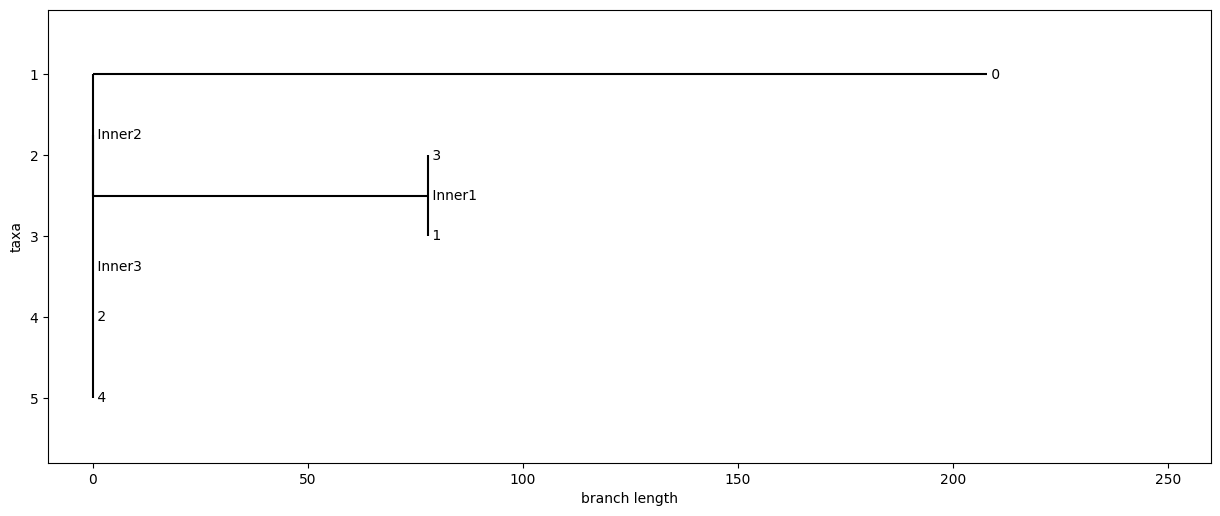

In [17]:
fig = plt.figure(figsize=(15, 6), dpi=100)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes)

In [18]:
operationsStack = []

def backtrack(matrix, row, column):
    global operationsStack

    leftNeighbor = matrix[row][column-1]
    cornerNeighbor = matrix[row-1][column-1]
    upperNeighbor = matrix[row-1][column]

    # Try to reach 0,0 point
    if row == 0 and column == 0:
        return

    # First check if copy is possible
    if max(leftNeighbor, cornerNeighbor, upperNeighbor) == cornerNeighbor:
        if matrix[row][column] < cornerNeighbor:
            operationsStack.append("Mismatch")
        else:
            operationsStack.append("Match")
            
        backtrack(matrix, row-1, column-1)
    # Insertion and Deletion have the same cost
    elif max(leftNeighbor, cornerNeighbor, upperNeighbor) == leftNeighbor:
        operationsStack.append("Insertion")
        backtrack(matrix, row, column-1)
    elif max(leftNeighbor, cornerNeighbor, upperNeighbor) == upperNeighbor:
        operationsStack.append("Deletion")
        backtrack(matrix, row-1, column)


def distance_multiple(s1, s2):

    cost = -4
    reward = 5
    
    alignmentMatrix = np.zeros((s1.shape[1]+1, s2.shape[1]+1))

    for i in range(s1.shape[1]+1):
        alignmentMatrix[i][0] = i*cost
    
    for i in range(s2.shape[1]+1):
        alignmentMatrix[0][i] = i*cost
        
    for i in range(1,s1.shape[1]+1):
        for j in range(1,s2.shape[1]+1):
            
            if set(s1[:, i-1]) & set(s2[:, j-1]):
                alignmentMatrix[i][j] = max(
                    alignmentMatrix[i-1][j] + cost, # Delete
                    alignmentMatrix[i][j-1] + cost, # Insert
                    alignmentMatrix[i-1][j-1] + reward # Copy
                )
            else:
                alignmentMatrix[i][j] = max(
                    alignmentMatrix[i-1][j] + cost, # Delete
                    alignmentMatrix[i][j-1] + cost, # Insert
                    alignmentMatrix[i-1][j-1] + cost # Replace
                )
    return np.asarray(alignmentMatrix)

def align_multiple(seq1, seq2, operations):
    ops = operations.copy()
    ops.reverse()
    
    new_seq1 = np.zeros((seq1.shape[0], len(ops)), dtype=object)
    new_seq2 = np.zeros((seq2.shape[0], len(ops)), dtype=object)
    
    idx_seq1 = 0
    idx_seq2 = 0
    
    for idx, op in enumerate(ops):
        if op == "Match" or op == "Mismatch":
            new_seq1[:, idx] = seq1[:, idx_seq1]
            new_seq2[:, idx] = seq2[:, idx_seq2]
            idx_seq1 += 1
            idx_seq2 += 1
        elif op == "Insertion":
            new_seq1[:, idx] = np.asarray(["-"] * seq1.shape[0], dtype="object")
            new_seq2[:, idx] = seq2[:, idx]
            idx_seq2 += 1
        elif op == "Deletion":
            new_seq1[:, idx] = seq1[:, idx_seq1]
            new_seq2[:, idx] = np.asarray(["-"] * seq2.shape[0], dtype="object")
            idx_seq1 += 1
            
    return np.vstack((new_seq1, new_seq2))

In [19]:
def align_wrapper(seq1, seq2):
    global operationsStack
    
    dist_matrix = distance_multiple(seq1, seq2)
    
    operationsStack = []
    backtrack(dist_matrix, seq1.shape[1], seq2.shape[1])
    
    aligned = align_multiple(seq1, seq2, operationsStack)
    
    return aligned
    
    
inner1 = align_wrapper(
                np.expand_dims(samples_unaligned[1], axis=0), 
                np.expand_dims(samples_unaligned[3], axis=0)
                )

inner2 = align_wrapper(
                inner1, 
                np.expand_dims(samples_unaligned[0], axis=0)
                )

inner3 = align_wrapper(
                np.expand_dims(samples_unaligned[2], axis=0), 
                np.expand_dims(samples_unaligned[4], axis=0)
                )

inner_all = align_wrapper(inner2, inner3)

#### f-)

Remember the alignment order: 
<ol>
  <li>inner1 = align(1, 3)</li>
  <li>inner2 = align(inner1, 0)</li>
  <li>inner3 = align(2, 4)</li>
  <li>innerFinal = align(inner2, inner3)</li>
</ol> 


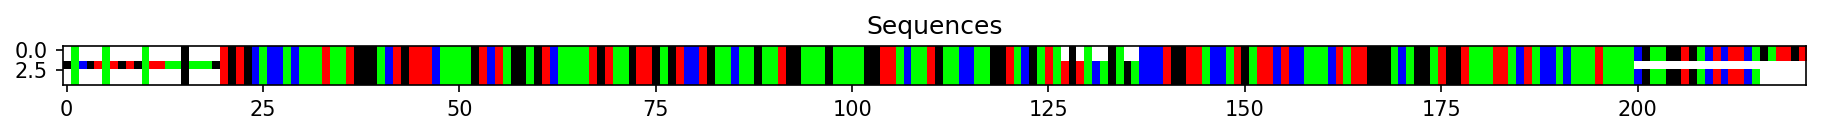

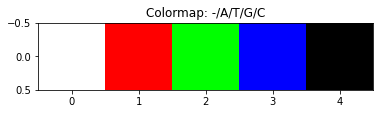

In [20]:
visualize(inner_all, inner_all.shape[1])

### Question 3-)

In [21]:
aligned_3nov = main_path + "England (NOV032020)/HCOV19-ENGLAND-031120-A.fasta"
aligned_27nov = main_path + "England (NOV272020)/HCOV19-ENGLAND-271120-A.fasta"
aligned_8dec = main_path + "England (DEC082020)/HCOV19-ENGLAND-081220-A.fasta"

samples_3nov = get_samples(path=aligned_3nov, n=4)[:, 21563:25385]
samples_27nov = get_samples(path=aligned_27nov, n=4)[:, 21563:25385]
samples_8dec = get_samples(path=aligned_8dec, n=4)[:, 21563:25385]

samples_12 = np.vstack((samples_3nov, samples_27nov, samples_8dec))
samples_12_obj = convert2Phylo(samples_12)

In [22]:
samples_12.shape

(12, 3822)

#### a-)

**Note that** the distance matrix is read from the file _3a_distmatrix.npy_ while testing because it take so much time to compute. This is done for acceleration.

In [40]:
import os

dist_matrix_filename = "3a_distmatrix.npy"

if dist_matrix_filename in os.listdir("."):
    with open(dist_matrix_filename, "br") as dm_file:
        dm_12 = np.load(dm_file)
else:
    dm_12 = distance_matrix(samples_12)
    with open(dist_matrix_filename, "bw+") as dm_file:
        np.save(dm_file, dm_12)

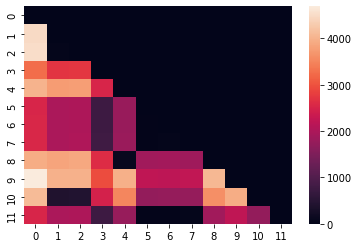

In [41]:
# plotting the heatmap
hm = sn.heatmap(data = dm_12)
  
# displaying the plotted heatmap
plt.show()

#### b-)

I did not used the Newick format because I implemented the solution before the updates. I rather used Clades.

In [26]:
def upgm_helper(distance_matrix, clades):
    
    min_value = np.inf
    min_indices = (0,0)
    
    for i in range(distance_matrix.shape[0]):
        for j in range(distance_matrix.shape[1]):
            if distance_matrix[i,j] < min_value and distance_matrix[i,j] > 0:
                min_value = distance_matrix[i,j]
                min_indices = (i,j)
        
    seq_id1 = min_indices[0]
    seq_id2 = min_indices[1]

    
    seq1_clade = clades[seq_id1]
    seq2_clade = clades[seq_id2]
    
    new_clade = Clade(
        branch_length = distance_matrix[seq_id1, seq_id2]/2,
        clades = [seq1_clade, seq2_clade]
    )
        
    clades[seq_id1] = new_clade
    del clades[seq_id2]
    
    row_mean = (distance_matrix[seq_id1] + distance_matrix[seq_id2])/2
    row_mean[seq_id1] = 0
    row_mean[seq_id2] = 0
    #row_mean = np.delete(row_mean, seq_id2, axis=0)
    
    col_mean = (distance_matrix[:,seq_id1] + distance_matrix[:, seq_id2])/2
    col_mean[seq_id1] = 0
    col_mean[seq_id2] = 0
    #col_mean = np.delete(col_mean, seq_id2, axis=0)
    
    distance_matrix[seq_id1] = row_mean
    distance_matrix[:, seq_id1] = col_mean
    
    #print("{} is now {}and{}".format(seq_id1, seq_id1, seq_id2))
    
    
    distance_matrix = np.delete(distance_matrix, seq_id2, axis=0)
    distance_matrix = np.delete(distance_matrix, seq_id2, axis=1)
        
    
    return distance_matrix, min_indices, clades


def upgm(distance_matrix, clades):
    dist_matrix = distance_matrix.copy()
    dm, indices, clades = upgm_helper(dist_matrix, clades.copy())
    #print(dm)
    #print(clades)
    return dm, clades

def construct_upgm(distance_matrix):
    clades = [
        Clade(branch_length=0, name="seq{}".format(i)) for i in range(distance_matrix.shape[0])
    ]
    clades_new = clades
    dm_new = distance_matrix.copy()
    while len(clades_new) > 1:
        dm_new, clades_new = upgm(dm_new, clades_new)
    my_upgma_tree = Tree(root= clades_new[0], rooted=True)
    
    return my_upgma_tree
    

In [27]:
my_upgma_tree = construct_upgm(dm_12) # TODO

#### c-)

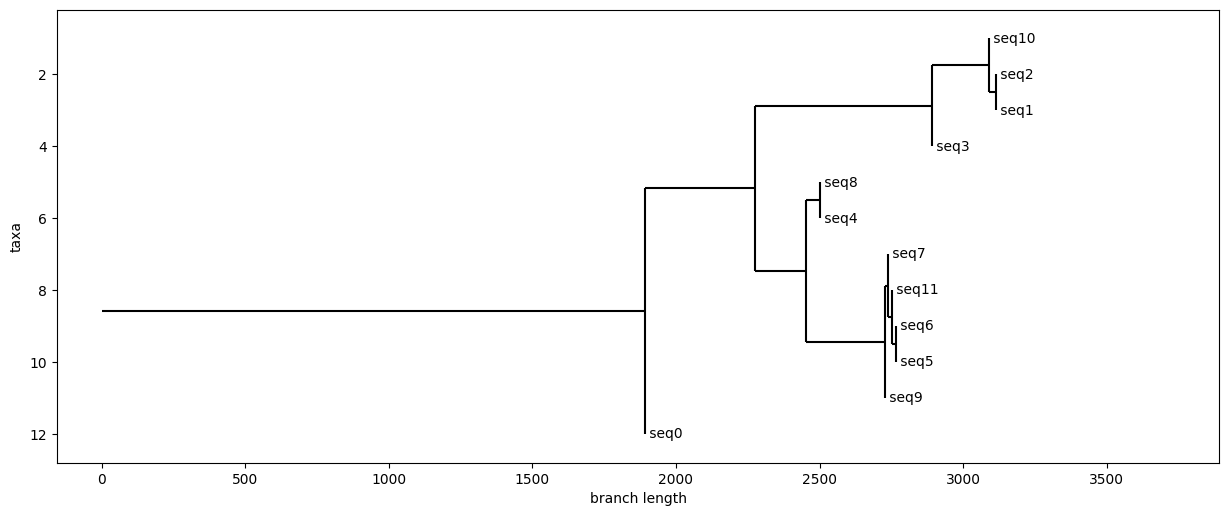

In [28]:
fig = plt.figure(figsize=(15, 6), dpi=100)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(my_upgma_tree, axes=axes)

#### d-)

In [43]:
dm12_converted = []

for i in range(dm_12.shape[0]):
    dm12_converted.append(dm_12[i, :i+1].tolist())
    
dm12_converted = DistanceMatrix(names=[str(i) for i in range(dm_12.shape[0])], matrix=dm12_converted)

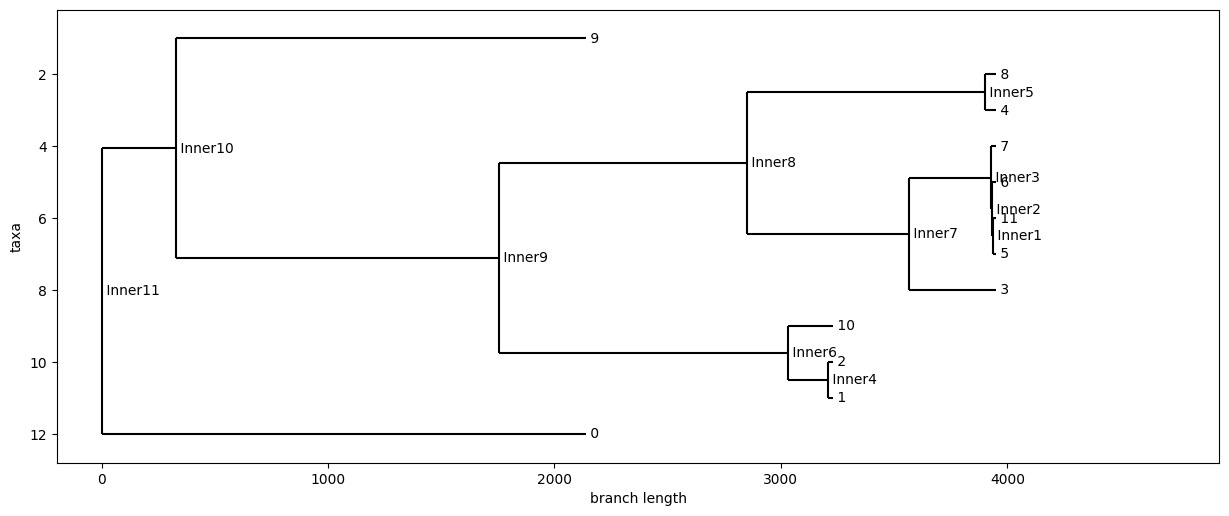

In [36]:
tree = constructor.upgma(dm12_converted) 
fig = plt.figure(figsize=(15, 6), dpi=100)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes)

There is some obvisous differences between my tree and the tree _Phylo_ constructed. The reason is the construction order. For example, mine tree started to align from 5th and 6th sequences which have 0 distance according to the matrix **3.a**. However, we see that _Phylo_ alignes sequnce 5 with sequence 11, where their pairwise distance is also zero. This choices results the difference in the trees. 

#### e-)

In [37]:
samples_3nov_all = get_samples(path=aligned_3nov, n=-1)[:, 21563:25385]
samples_27nov_all = get_samples(path=aligned_27nov, n=-1)[:, 21563:25385]
samples_8dec_all = get_samples(path=aligned_8dec, n=-1)[:, 21563:25385]
samples_all = np.vstack((samples_3nov_all, samples_27nov_all, samples_8dec_all))
print(samples_all.shape)
samples_all_obj = convert2Phylo(samples_all)

(298, 3822)


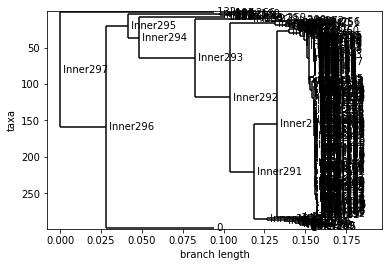

In [42]:
# I used the hamming distance of Phylo bcs its faster
calculator = DistanceCalculator('identity')

dm = calculator.get_distance(samples_all_obj)

tree = constructor.upgma(dm)

Phylo.draw(tree)